In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import auth
auth.authenticate_user()

In [44]:
# Importing libraries and initializing GCS client
from google.cloud import storage
import pandas as pd
from io import StringIO
import io
import csv
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
import random
from tqdm import tqdm
import os

client = storage.Client()
bucket_name = "nutrition5k_dataset"
bucket = client.bucket(bucket_name)

In [5]:
# Creating ingredients dataframe
file_path = "nutrition5k_dataset/metadata/ingredients_metadata.csv"
blob = bucket.blob(file_path)
content = blob.download_as_text()

ingredients = pd.read_csv(StringIO(content))
ingredients

,ingr,id,cal/g,fat(g),carb(g),protein(g)
0,cottage cheese,1,0.980,0.043,0.034,0.110
1,strawberries,2,0.330,0.003,0.080,0.007
2,garden salad,3,0.646,0.034,0.032,0.061
3,bacon,4,5.410,0.420,0.014,0.370
4,potatoes,5,0.770,0.001,0.170,0.020
...,...,...,...,...,...,...
550,pizza sauce,551,0.290,0.002,0.070,0.013
551,pomegranate,552,0.830,0.012,0.190,0.017
552,nut cheese,553,2.100,0.101,0.040,0.256
553,soy sausage,554,2.020,0.144,0.063,0.160


In [6]:
# Reading dish information

# Path to the metadata file
file_paths = [
    "nutrition5k_dataset/metadata/dish_metadata_cafe1.csv",
    "nutrition5k_dataset/metadata/dish_metadata_cafe2.csv"
]

# Lists to store parsed data
dish_data = []
ingredients_data = []

# Iterating over the files
for file_path in file_paths:

    # Get the file from GCS
    blob = bucket.blob(file_path)
    content = blob.download_as_text()

    # Read CSV line-by-line
    reader = csv.reader(StringIO(content))
    for row in reader:
        # Parse dish-level info
        dish_id = row[0]
        total_mass = float(row[1])
        total_calories = float(row[2])
        total_fat = float(row[3])
        total_carb = float(row[4])
        total_protein = float(row[5])

        dish_data.append({
            "dish_id": dish_id,
            "total_mass": total_mass,
            "total_calories": total_calories,
            "total_fat": total_fat,
            "total_carb": total_carb,
            "total_protein": total_protein
        })

        # Each ingredient block is 7 fields, starting from index 6
        for i in range(6, len(row), 7):
            try:
                ingredients_data.append({
                    "dish_id": dish_id,
                    "ingr_id": row[i],
                    "ingr_name": row[i + 1],
                    "grams": float(row[i + 2]),
                    "calories": float(row[i + 3]),
                    "fat": float(row[i + 4]),
                    "carb": float(row[i + 5]),
                    "protein": float(row[i + 6])
                })
            except IndexError:
                print(f"⚠️ Skipping incomplete ingredient block for dish {dish_id}")
                continue

# Convert to pandas DataFrames
dishes = pd.DataFrame(dish_data)
dish_ingredients = pd.DataFrame(ingredients_data)

# Display samples
print("✅ Dish Metadata:")
display(dishes)

print("✅ Ingredient Metadata:")
display(dish_ingredients)


✅ Dish Metadata:


,dish_id,total_mass,total_calories,total_fat,total_carb,total_protein
0,dish_1561662216,300.794281,193.0,12.387489,28.218290,18.633970
1,dish_1562688426,137.569992,88.0,8.256000,5.190000,10.297000
2,dish_1561662054,419.438782,292.0,23.838249,26.351543,25.910593
3,dish_1562008979,382.936646,290.0,22.224644,10.173570,35.345387
4,dish_1560455030,20.590000,103.0,0.148000,4.625000,0.956000
...,...,...,...,...,...,...
5001,dish_1571934465,0.000000,232.0,0.000000,0.000000,0.000000
5002,dish_1573073666,0.000000,15.0,0.000000,0.000000,0.000000
5003,dish_1575924356,0.000000,103.0,0.000000,0.000000,0.000000
5004,dish_1574359199,0.000000,329.0,0.000000,0.000000,0.000000


✅ Ingredient Metadata:


,dish_id,ingr_id,ingr_name,grams,calories,fat,carb,protein
0,dish_1561662216,ingr_0000000508,soy sauce,3.398568,1.801241,0.020391,0.166530,0.275284
1,dish_1561662216,ingr_0000000122,garlic,2.124105,3.164916,0.010621,0.700955,0.135943
2,dish_1561662216,ingr_0000000026,white rice,8.496420,11.045346,0.025489,2.378998,0.229403
3,dish_1561662216,ingr_0000000524,parsley,0.213397,0.079170,0.001707,0.013657,0.006189
4,dish_1561662216,ingr_0000000094,onions,1.707173,0.682869,0.001707,0.153646,0.018779
...,...,...,...,...,...,...,...,...
28450,dish_1576171157,ingr_0000000077,almonds,0.294420,1.702042,0.145738,0.066833,0.065950
28451,dish_1576171157,ingr_0000000161,olive oil,1.430858,12.648785,1.430858,0.000000,0.000000
28452,dish_1576171157,ingr_0000000203,chili,0.953905,0.381562,0.003816,0.084898,0.017170
28453,dish_1576171157,ingr_0000000291,salt,0.008412,0.000000,0.000000,0.000000,0.000000


In [7]:
dishes.describe()

,total_mass,total_calories,total_fat,total_carb,total_protein
count,5006.000000,5006.000000,5006.000000,5006.000000,5006.000000
mean,213.332125,189.980224,10.721587,17.002987,14.476484
std,308.762649,269.299511,24.455768,28.680633,18.561609
min,0.000000,1.000000,0.000000,0.000000,0.000000
25%,49.939999,73.000000,0.378500,4.338500,1.296000
50%,141.699997,145.000000,5.823762,11.801218,7.047808
75%,314.518776,257.000000,15.447732,23.570615,21.463784
max,9485.815430,7975.000000,875.541016,844.568604,147.491821


In [8]:
dish_ingredients.groupby('dish_id').agg({
    'grams': 'sum',
    'calories': 'sum',
    'fat': 'sum',
    'carb': 'sum',
    'protein': 'sum'
}).reset_index().describe()

,grams,calories,fat,carb,protein
count,5006.000000,5006.000000,5006.000000,5006.000000,5006.000000
mean,194.735118,225.276178,11.400673,17.761557,15.182375
std,319.632718,307.194723,24.482667,28.617862,18.453208
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,63.615000,0.699398,5.093156,1.746000
50%,145.000001,158.402746,6.745500,12.646951,8.473551
75%,258.000000,324.398000,16.271844,24.200000,22.271251
max,8094.000000,9485.816000,875.541000,844.568692,147.491801


In [12]:
# Loading RGB images

# Folder prefix (use exact path from screenshot)
prefix = "nutrition5k_dataset/imagery/realsense_overhead/"
image_to_load = "rgb.png"

# List all blobs in the folder (recursively)
blobs = bucket.list_blobs(prefix=prefix)

# Filter only rgb.png files
rgb_blobs = [blob.download_as_bytes() for blob in tqdm(list(blobs)[:100]) if blob.name.endswith(image_to_load)]

100%|██████████| 100/100 [00:02<00:00, 38.23it/s]


In [54]:
prefix = "nutrition5k_dataset/imagery/realsense_overhead"
blobs = bucket.list_blobs(prefix=prefix)
dish_paths = list(set(['/'.join(blob.name.split('/')[:-1]) for blob in blobs]))

def return_image_as_bytes(file_path, image_to_get):
    file_path = os.path.join(file_path, image_to_get)
    blob = bucket.blob(file_path)
    return blob.download_as_bytes()

rgb_images = [return_image_as_bytes(path, 'rgb.png') for path in tqdm(dish_paths)]
depth_images = [return_image_as_bytes(path, 'depth_color.png') for path in tqdm(dish_paths)]

image_df = pd.DataFrame().from_dict({
    'dish': [path.split('/')[-1] for path in dish_paths],
    'rgb_image': rgb_images,
    'depth_image': depth_images
})
image_df

Output hidden; open in https://colab.research.google.com to view.

In [58]:
save_path = '/content/drive/MyDrive/Nutrition5kDataset'
image_df.to_pickle(os.path.join(save_path, 'dish_images.pkl'))
# dishes.to_excel(os.path.join(save_path, 'dishes.xlsx'), index=False)
# dish_ingredients.to_excel(os.path.join(save_path, 'dish_ingredients.xlsx'), index=False)
# ingredients.to_excel(os.path.join(save_path, 'ingredients.xlsx'), index=False)

In [42]:
image_df

Output hidden; open in https://colab.research.google.com to view.

In [49]:
image_df = pd.merge(image_df, dishes, left_on='dish', right_on='dish_id', how='left').drop('dish_id', axis=1)
image_df

Output hidden; open in https://colab.research.google.com to view.

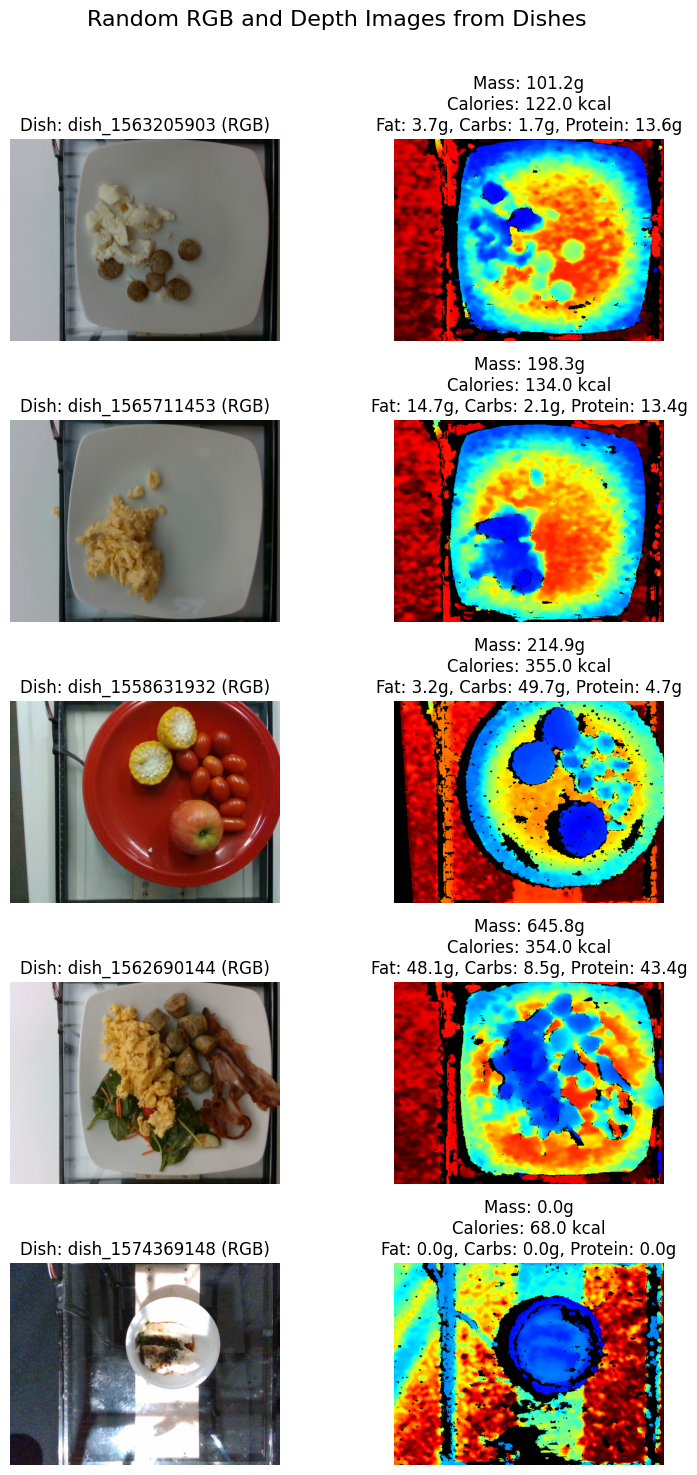

In [52]:
# Pick 5 random rows
sample_df = image_df.sample(5, random_state=42).reset_index(drop=True)

# Plot the images
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8, 15))
fig.suptitle("Random RGB and Depth Images from Dishes", fontsize=16)

for i in range(5):
    # Decode RGB image
    rgb_bytes = sample_df.loc[i, 'rgb_image']
    rgb_image = Image.open(io.BytesIO(rgb_bytes))

    # Decode Depth image
    depth_bytes = sample_df.loc[i, 'depth_image']
    depth_image = Image.open(io.BytesIO(depth_bytes))

    # Plot RGB
    axes[i, 0].imshow(rgb_image)
    axes[i, 0].set_title(f"Dish: {sample_df.loc[i, 'dish']} (RGB)")
    axes[i, 0].axis('off')

    # Nutrient info
    title = (
        f"Mass: {sample_df.loc[i, 'total_mass']:.1f}g\n"
        f"Calories: {sample_df.loc[i, 'total_calories']:.1f} kcal\n"
        f"Fat: {sample_df.loc[i, 'total_fat']:.1f}g, "
        f"Carbs: {sample_df.loc[i, 'total_carb']:.1f}g, "
        f"Protein: {sample_df.loc[i, 'total_protein']:.1f}g"
    )

    # Plot Depth
    axes[i, 1].imshow(depth_image, cmap='plasma')
    axes[i, 1].set_title(title)
    axes[i, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()